<a href="https://colab.research.google.com/github/M-Abbi/Financial-Modeling/blob/main/LSTM_Stock_Price_Prediction_(Fixed).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - loss: 0.0467 - val_loss: 0.0062
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 8.9738e-04 - val_loss: 0.0021
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 8.4286e-04 - val_loss: 0.0021
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 8.8296e-04 - val_loss: 0.0020
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 8.0255e-04 - val_loss: 0.0022
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 8.9421e-04 - val_loss: 0.0020
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 7.8340e-04 - val_loss: 0.0020
Epoch 9/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 7.9577e-04 - val_loss: 0.0018
Epoch 10/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 7.6242e-04 - val_loss: 0.0019
Epoch 11/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 7.2078e-04 - val_loss: 0.0017
Epoch 12/20
32/32 ━━━━━━━━━

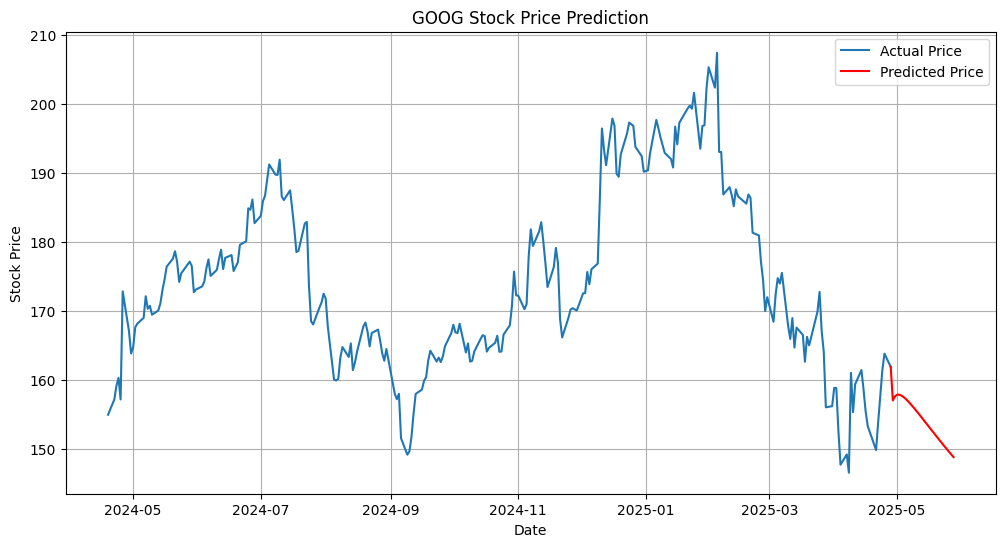


Predicted Prices:
2025-04-28: 157.06
2025-04-29: 157.65
2025-04-30: 157.88
2025-05-01: 157.90
2025-05-02: 157.79
2025-05-03: 157.58
2025-05-04: 157.33
2025-05-05: 157.03
2025-05-06: 156.71
2025-05-07: 156.36
2025-05-08: 156.01
2025-05-09: 155.64
2025-05-10: 155.27
2025-05-11: 154.89
2025-05-12: 154.50
2025-05-13: 154.12
2025-05-14: 153.73
2025-05-15: 153.34
2025-05-16: 152.95
2025-05-17: 152.57
2025-05-18: 152.18
2025-05-19: 151.80
2025-05-20: 151.42
2025-05-21: 151.04
2025-05-22: 150.67
2025-05-23: 150.30
2025-05-24: 149.93
2025-05-25: 149.56
2025-05-26: 149.20
2025-05-27: 148.84


In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# 1. Define the Stock Symbol and Timeframe
stock_symbol = 'GOOG'  # Example: Apple Inc.
start_date = '2020-01-01'
end_date = '2025-12-31'
prediction_days = 30  # Number ofdays to predict into the future

# 2. Download Historical Stock Data
try:
    data = yf.download(stock_symbol, start=start_date, end=end_date)
except Exception as e:
    print(f"Error downloading data for {stock_symbol}: {e}")
    exit()

# 3. Prepare the Data
# We'll use the 'Close' price for forecasting
close_prices = data['Close'].values.reshape(-1, 1)

# Scale the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(close_prices)

# Create sequences for the LSTM
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        seq = data[i : i + seq_length]
        label = data[i + seq_length]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

sequence_length = 60  # Number of past days to consider for prediction
X, y = create_sequences(scaled_prices, sequence_length)

# Split data into training and testing sets
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 4. Build the LSTM Model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(sequence_length, 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# 5. Train the Model
epochs = 20
batch_size = 32
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=1)

# 6. Make Predictions
# Prepare the last 'sequence_length' days of data for prediction
last_sequence = scaled_prices[-sequence_length:].reshape((1, sequence_length, 1)) # Reshape for correct dimensions

# Predict the next 'prediction_days'
predictions_scaled = []
for _ in range(prediction_days):
    next_price_scaled = model.predict(last_sequence)
    predictions_scaled.append(next_price_scaled[0, 0])
    last_sequence = np.append(last_sequence[:, 1:, :], next_price_scaled.reshape(1, 1, 1), axis=1) # Reshape next_price_scaled

# Inverse transform the scaled predictions
predictions = scaler.inverse_transform(np.array(predictions_scaled).reshape(-1, 1))

# 7. Visualize the Results
# Get the actual prices for the test period
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

# Create a date range for the predicted values
last_date = data.index[-1]
prediction_dates = pd.date_range(start=last_date, periods=prediction_days + 1) # Removed 'closed' argument

plt.figure(figsize=(12, 6))
plt.plot(data.index[-len(actual_prices):], actual_prices, label='Actual Price')
# Ensure both arrays are 1D for concatenation
plt.plot(prediction_dates, np.concatenate((actual_prices[-1:].flatten(), predictions.flatten())), label='Predicted Price', color='red')
plt.title(f'{stock_symbol} Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

# Optionally, you can print the predicted prices
print("\nPredicted Prices:")
for i, price in enumerate(predictions):
    print(f"{prediction_dates[i].strftime('%Y-%m-%d')}: {price[0]:.2f}")
